In [ ]:
# Paso 1: Instalar librerías necesarias (solo la primera vez)
!pip install spacy wordcloud
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 99.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# EDA

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
# Paso 2: Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import spacy

# spaCy model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Paso 3: Cargar los datos
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
val_df = pd.read_csv('validation.csv')

print("Train:")
print(train_df.head())
print("\nTest:")
print(test_df.head())
print("\nValidation:")
print(val_df.head())


Train:
                                                text  label
0  the rock is destined to be the 21st century's ...      1
1  the gorgeously elaborate continuation of " the...      1
2                     effective but too-tepid biopic      1
3  if you sometimes like to go to the movies to h...      1
4  emerges as something rare , an issue movie tha...      1

Test:
                                                text  label
0  the rock is destined to be the 21st century's ...      1
1  the gorgeously elaborate continuation of " the...      1
2                     effective but too-tepid biopic      1
3  if you sometimes like to go to the movies to h...      1
4  emerges as something rare , an issue movie tha...      1

Validation:
                                                text  label
0  the rock is destined to be the 21st century's ...      1
1  the gorgeously elaborate continuation of " the...      1
2                     effective but too-tepid biopic      1
3  if you som

In [ ]:
# Paso 4: Inspección básica
print("Columnas:", train_df.columns)
print("Clases:", train_df['label'].value_counts())

# Info general
train_df.info()


Columnas: Index(['text', 'label'], dtype='object')
Clases: label
1    4265
0    4265
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8530 entries, 0 to 8529
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8530 non-null   object
 1   label   8530 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.4+ KB


In [ ]:
train_df.describe()

,label
count,8530.000000
mean,0.500000
std,0.500029
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
# Verificar valores nulos en cada columna
print(train_df.isnull().sum())

# También puedes visualizarlo en porcentaje
print("\nPorcentaje de valores nulos:")
print((train_df.isnull().sum() / len(train_df)) * 100)


text     0
label    0
dtype: int64

Porcentaje de valores nulos:
text     0.0
label    0.0
dtype: float64


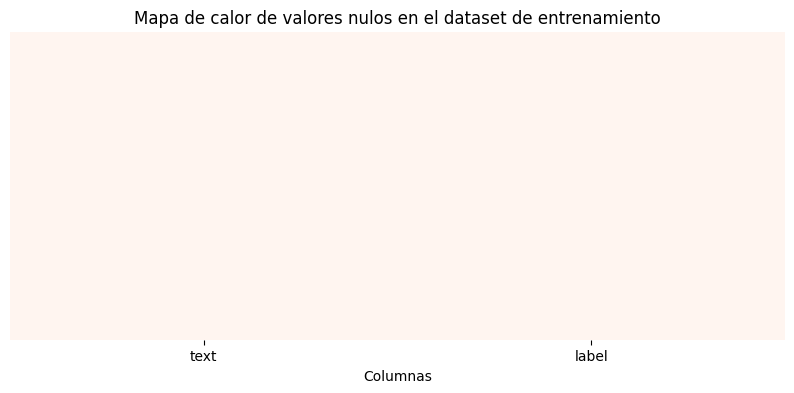

In [ ]:
plt.figure(figsize=(10, 4))
sns.heatmap(train_df.isnull(), cbar=False, cmap="Reds", yticklabels=False)
plt.title("Mapa de calor de valores nulos en el dataset de entrenamiento")
plt.xlabel("Columnas")
plt.show()

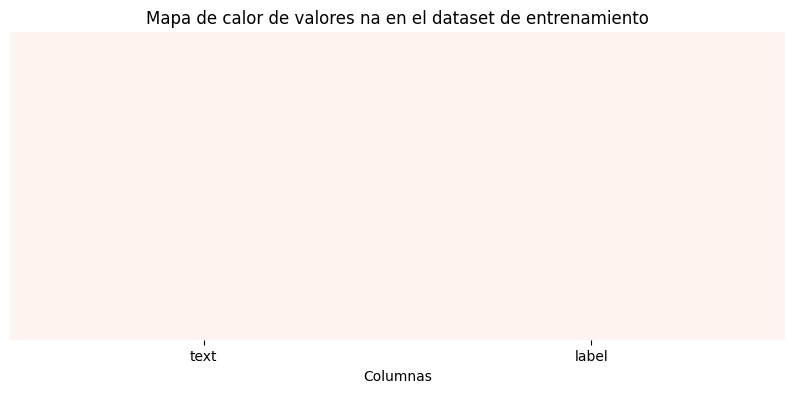

In [ ]:
plt.figure(figsize=(10, 4))
sns.heatmap(train_df.isna(), cbar=False, cmap="Reds", yticklabels=False)
plt.title("Mapa de calor de valores na en el dataset de entrenamiento")
plt.xlabel("Columnas")
plt.show()

In [ ]:
duplicados = train_df.duplicated()

print(f"Número de filas duplicadas: {duplicados.sum()}")

if duplicados.any():
    print("\nFilas duplicadas:")
    print(train_df[duplicados].head())


Número de filas duplicadas: 0


In [ ]:
train_df.duplicated(subset='text').sum()

np.int64(0)

In [ ]:
train_df.duplicated(subset='label').sum()

np.int64(8528)

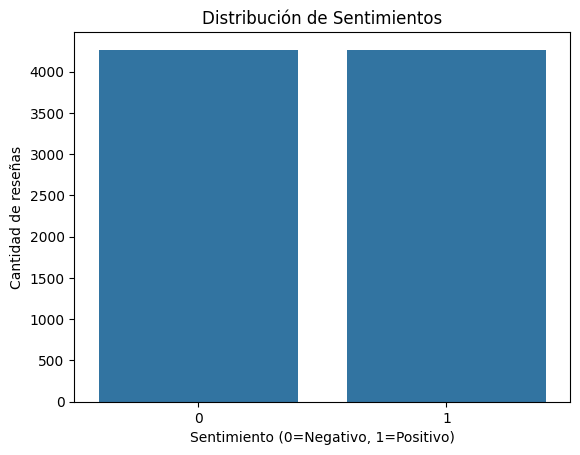

In [ ]:
sns.countplot(x='label', data=train_df)
plt.title("Distribución de Sentimientos")
plt.xlabel("Sentimiento (0=Negativo, 1=Positivo)")
plt.ylabel("Cantidad de reseñas")
plt.show()

In [ ]:
def normalizacion(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if (not token.is_stop and not token.is_punct and not token.is_digit
            and token.is_alpha and len(token.text) >= 2)
    ]
    return ' '.join(tokens)

train_df['tokens'] = train_df['text'].apply(normalizacion)


In [ ]:
print(train_df[['text','tokens']].head())

                                                text  \
0  the rock is destined to be the 21st century's ...   
1  the gorgeously elaborate continuation of " the...   
2                     effective but too-tepid biopic   
3  if you sometimes like to go to the movies to h...   
4  emerges as something rare , an issue movie tha...   

                                              tokens  
0  rock destine century new conan go splash great...  
1  gorgeously elaborate continuation lord ring tr...  
2                             effective tepid biopic  
3             like movie fun wasabi good place start  
4  emerge rare issue movie honest keenly observe ...  


/tmp/ipython-input-12-2688659302.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs_pos), y=list(words_pos), ax=axes[0], palette="Greens")
/tmp/ipython-input-12-2688659302.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs_neg), y=list(words_neg), ax=axes[1], palette="Reds")


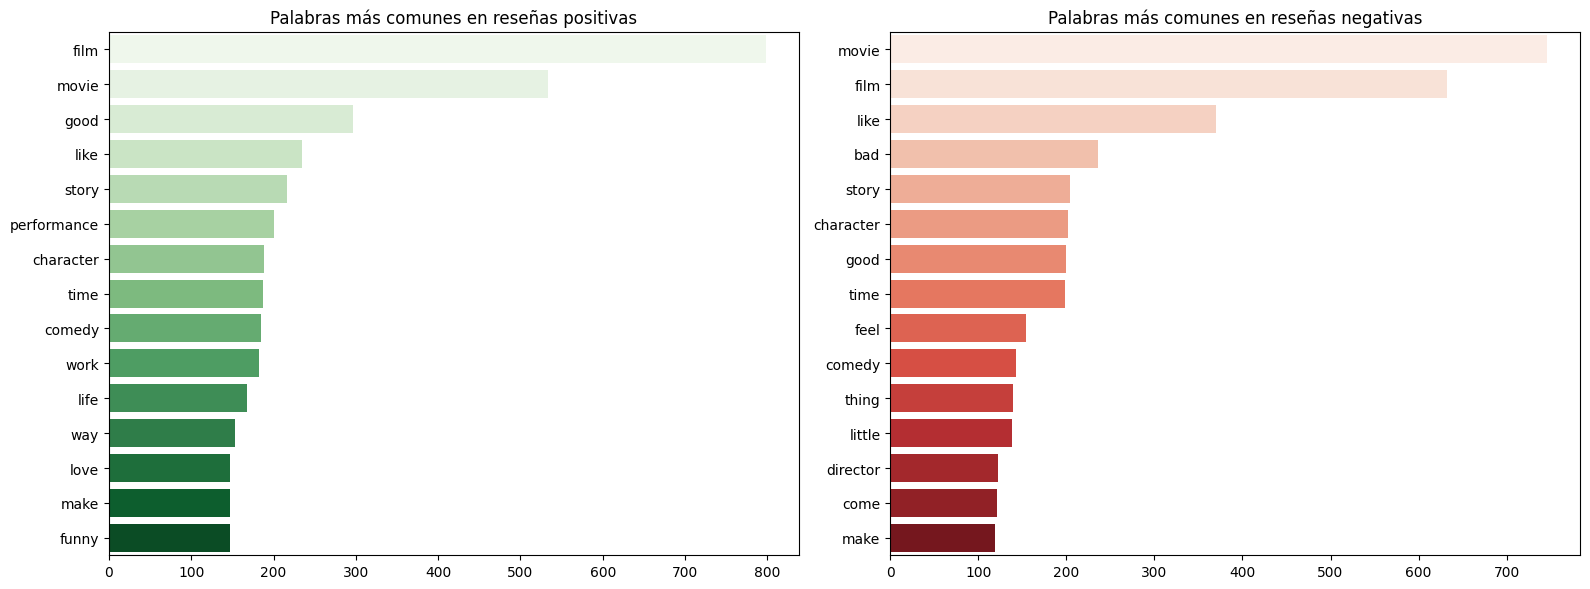

In [ ]:
positive_words = ' '.join(train_df[train_df['label'] == 1]['tokens']).split()
negative_words = ' '.join(train_df[train_df['label'] == 0]['tokens']).split()

positive_freq = Counter(positive_words).most_common(15)
negative_freq = Counter(negative_words).most_common(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positivas
words_pos, freqs_pos = zip(*positive_freq)
sns.barplot(x=list(freqs_pos), y=list(words_pos), ax=axes[0], palette="Greens")
axes[0].set_title("Palabras más comunes en reseñas positivas")

# Negativas
words_neg, freqs_neg = zip(*negative_freq)
sns.barplot(x=list(freqs_neg), y=list(words_neg), ax=axes[1], palette="Reds")
axes[1].set_title("Palabras más comunes en reseñas negativas")

plt.tight_layout()
plt.show()


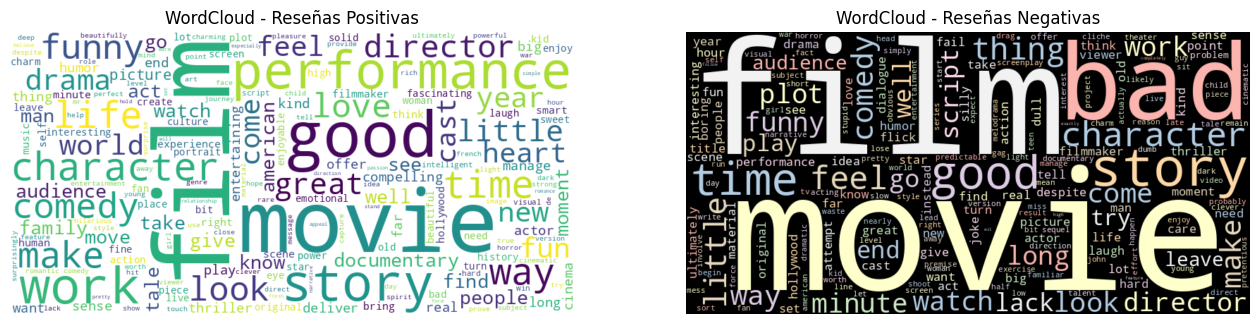

In [ ]:
# Paso 8: WordCloud por clase
positive_text = ' '.join(train_df[train_df['label'] == 1]['tokens'])
negative_text = ' '.join(train_df[train_df['label'] == 0]['tokens'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Pastel1').generate(negative_text)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Reseñas Positivas")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Reseñas Negativas")

plt.show()


# Preprocesamiento para el modelo

In [ ]:
all_words = list(set(positive_words + negative_words))

In [ ]:
word_sentiment_freq = {}
for word in all_words:
    word_sentiment_freq[word] = {'positive': 0, 'negative': 0}

In [ ]:
for word in positive_words:
    word_sentiment_freq[word]['positive'] += 1
for word in negative_words:
    word_sentiment_freq[word]['negative'] += 1

In [ ]:
word_sentiment_ratio = {}
for word, freqs in word_sentiment_freq.items():
    total_freq = freqs['positive'] + freqs['negative']
    if total_freq > 0:
        word_sentiment_ratio[word] = {
            'positive': freqs['positive'] / total_freq,
            'negative': freqs['negative'] / total_freq
        }
    else:
        word_sentiment_ratio[word] = {'positive': 0, 'negative': 0}

In [ ]:
neutrality_threshold = 0.3 #la frecuencia de una palabra debe ser el 30% o más en ambas categorias para ser neutral

neutral_words = [
    word for word, ratios in word_sentiment_ratio.items()
    if abs(ratios['positive'] - ratios['negative']) < neutrality_threshold
]

In [ ]:
print(f"\nNúmero de palabras identificadas como neutras (diferencia de proporción < {neutrality_threshold}): {len(neutral_words)}")
print("Ejemplo de palabras neutras:", neutral_words[:10])


Número de palabras identificadas como neutras (diferencia de proporción < 0.3): 2515
Ejemplo de palabras neutras: ['fork', 'thousand', 'discuss', 'wholly', 'humor', 'possibility', 'scenery', 'giggle', 'disdain', 'gulp']


In [ ]:
#borra las palabras neutras
train_df['tokens_filtered'] = train_df['tokens'].apply(
    lambda tokens: ' '.join([word for word in tokens.split() if word not in neutral_words])
)

/tmp/ipython-input-21-1103802030.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs_pos), y=list(words_pos), ax=axes[0], palette="Greens")
/tmp/ipython-input-21-1103802030.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs_neg), y=list(words_neg), ax=axes[1], palette="Reds")


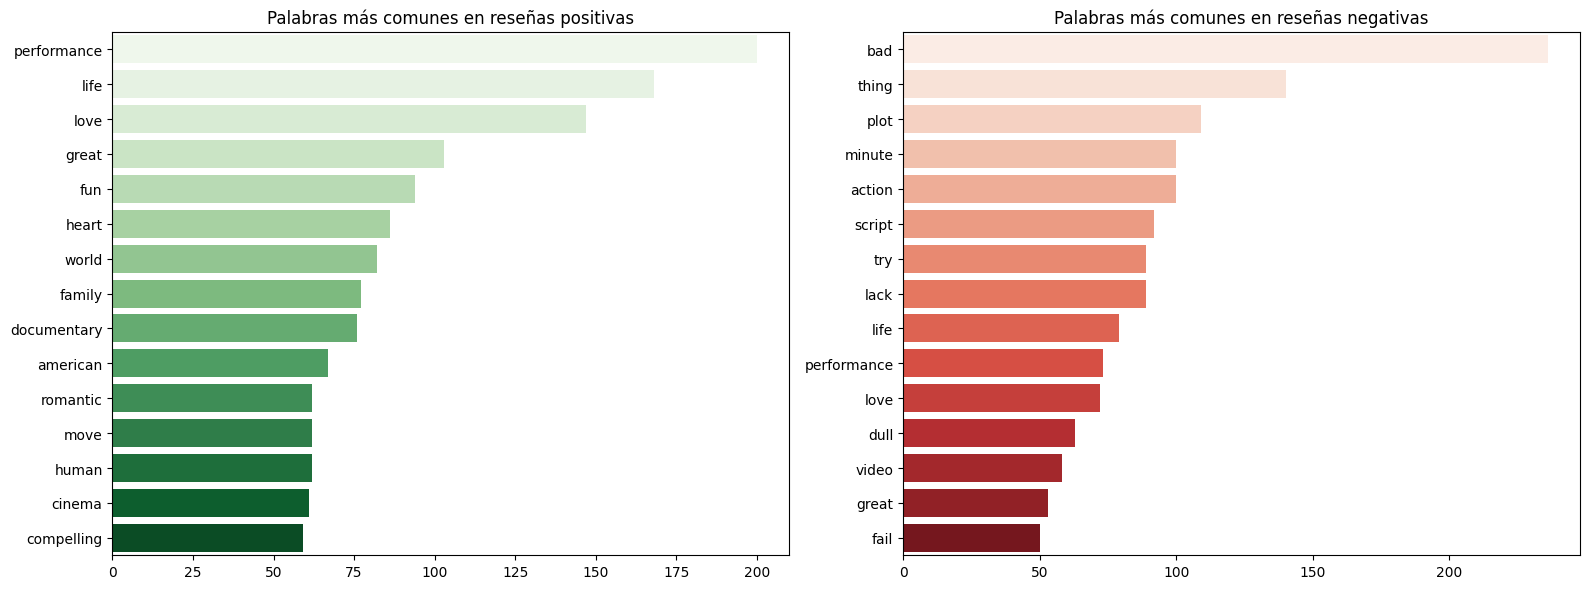

In [ ]:
positive_words = ' '.join(train_df[train_df['label'] == 1]['tokens_filtered']).split()
negative_words = ' '.join(train_df[train_df['label'] == 0]['tokens_filtered']).split()

positive_freq = Counter(positive_words).most_common(15)
negative_freq = Counter(negative_words).most_common(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positivas
words_pos, freqs_pos = zip(*positive_freq)
sns.barplot(x=list(freqs_pos), y=list(words_pos), ax=axes[0], palette="Greens")
axes[0].set_title("Palabras más comunes en reseñas positivas")

# Negativas
words_neg, freqs_neg = zip(*negative_freq)
sns.barplot(x=list(freqs_neg), y=list(words_neg), ax=axes[1], palette="Reds")
axes[1].set_title("Palabras más comunes en reseñas negativas")

plt.tight_layout()
plt.show()

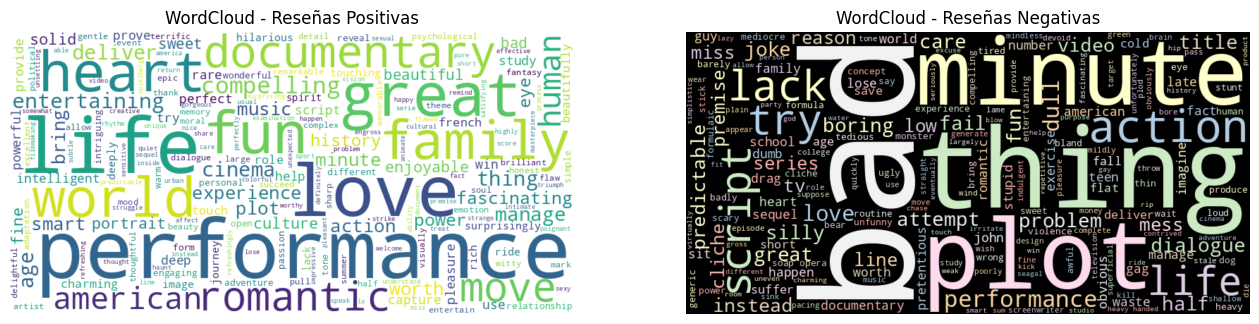

In [ ]:
positive_text = ' '.join(train_df[train_df['label'] == 1]['tokens_filtered'])
negative_text = ' '.join(train_df[train_df['label'] == 0]['tokens_filtered'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Pastel1').generate(negative_text)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Reseñas Positivas")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Reseñas Negativas")

plt.show()

# Preparación de datos para el entrenamiento

In [ ]:
#normalizacion de test y val
test_df['tokens'] = test_df['text'].apply(normalizacion)
val_df['tokens'] = val_df['text'].apply(normalizacion)

In [ ]:
test_df['tokens_filtered'] = test_df['tokens'].apply(
    lambda tokens: ' '.join([word for word in tokens.split() if word not in neutral_words])
)
val_df['tokens_filtered'] = val_df['tokens'].apply(
    lambda tokens: ' '.join([word for word in tokens.split() if word not in neutral_words])
)

In [ ]:
X_train = train_df['tokens_filtered']
y_train = train_df['label']

X_val = val_df['tokens_filtered']
y_val = val_df['label']

X_test = test_df['tokens_filtered']
y_test = test_df['label']

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
#convierte a array denso ara gnb
X_train_dense = X_train_tfidf.toarray()
X_val_dense = X_val_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Evaluación

**1 Regresión logística**

In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_val_pred_lr = lr_model.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_lr):.4f}")
print(classification_report(y_val, y_val_pred_lr))

Accuracy: 0.8855
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4265
           1       0.89      0.88      0.88      4265

    accuracy                           0.89      8530
   macro avg       0.89      0.89      0.89      8530
weighted avg       0.89      0.89      0.89      8530



**2 SVM**

In [ ]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [ ]:
y_val_pred_svm = svm_model.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_svm):.4f}")
print(classification_report(y_val, y_val_pred_svm))

Accuracy: 0.9053
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      4265
           1       0.91      0.90      0.90      4265

    accuracy                           0.91      8530
   macro avg       0.91      0.91      0.91      8530
weighted avg       0.91      0.91      0.91      8530



**3 Árboles de Decisión**

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_tfidf, y_train)

DecisionTreeClassifier()

In [ ]:
y_val_pred_dt = dt_model.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_dt):.4f}")
print(classification_report(y_val, y_val_pred_dt))

Accuracy: 0.9785
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4265
           1       0.99      0.96      0.98      4265

    accuracy                           0.98      8530
   macro avg       0.98      0.98      0.98      8530
weighted avg       0.98      0.98      0.98      8530



Psible overfitting en recall

**4 Gaussian Naive Bayes**

In [ ]:
gnb_model = GaussianNB()
gnb_model.fit(X_train_dense, y_train)

GaussianNB()

In [ ]:
y_val_pred_gnb = gnb_model.predict(X_val_dense)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_gnb):.4f}")
print(classification_report(y_val, y_val_pred_gnb))

Accuracy: 0.9020
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4265
           1       0.92      0.88      0.90      4265

    accuracy                           0.90      8530
   macro avg       0.90      0.90      0.90      8530
weighted avg       0.90      0.90      0.90      8530



In [ ]:
cm_lr = confusion_matrix(y_val, y_val_pred_lr)
cm_svm = confusion_matrix(y_val, y_val_pred_svm)
cm_dt = confusion_matrix(y_val, y_val_pred_dt)
cm_gnb = confusion_matrix(y_val, y_val_pred_gnb)

In [ ]:
model_names = ['Logistic Regression', 'SVM', 'Decision Tree', 'Gaussian Naive Bayes']
confusion_matrices = [cm_lr, cm_svm, cm_dt, cm_gnb]

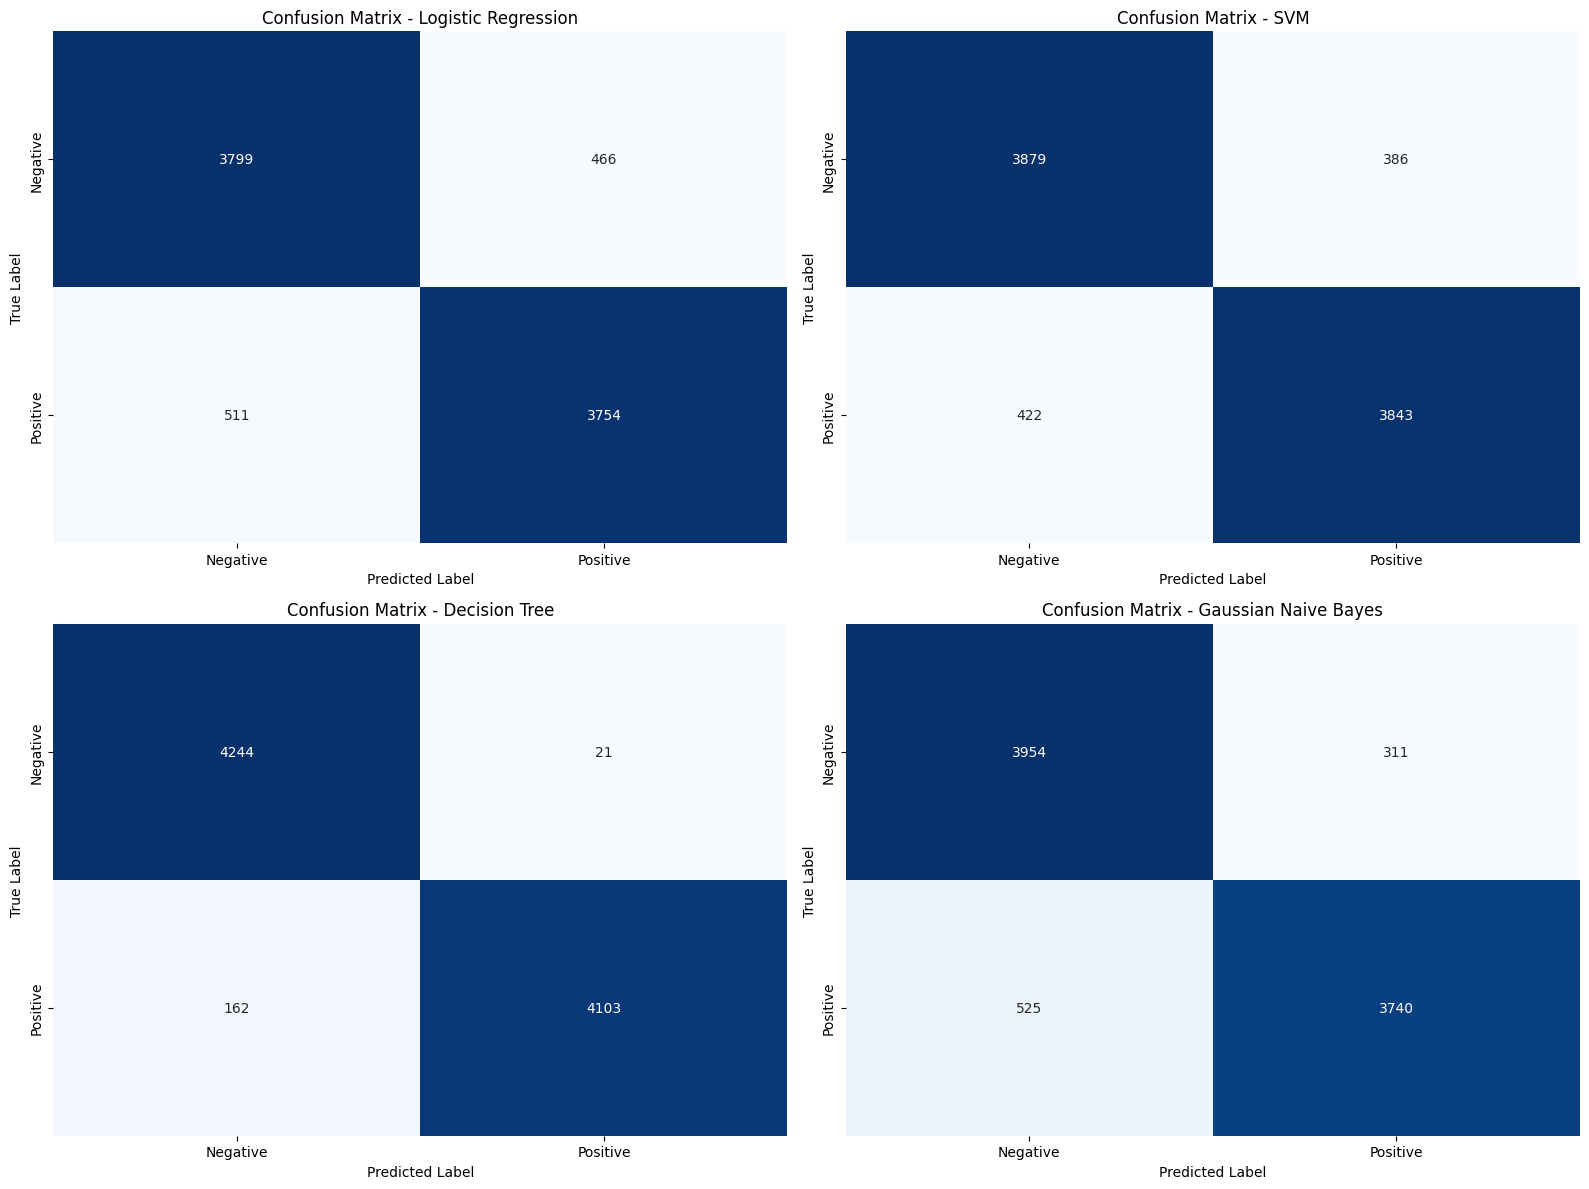

In [ ]:
plt.figure(figsize=(16, 12))
for i, cm in enumerate(confusion_matrices):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_names[i]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

decision tree presenta las mejores métricas y accuracy, pero existe un posible overfitting en recall

por eso se opta por SVM el cual tiene las segundas mejores métricas

# Archivos necesarios para la implementación

In [ ]:
import pickle
from google.colab import files

In [ ]:
#modelo
model_filename = 'svm_sentiment_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(svm_model, file)

In [ ]:
#vectorizador
vectorizer_filename = 'tfidf_vectorizer.pkl'
with open(vectorizer_filename, 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [ ]:
#palabras neutras (para el preprocesamiento)
neutral_words_filename = 'neutral_words.pkl'
with open(neutral_words_filename, 'wb') as file:
    pickle.dump(neutral_words, file)

In [ ]:
#modelo spacy (para normalizacion en otro entorno)
spacy_model_name = 'en_core_web_sm'
spacy_model_filename = 'spacy_model_name.txt'
with open(spacy_model_filename, 'w') as file:
    file.write(spacy_model_name)

In [ ]:
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download(vectorizer_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download(neutral_words_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download(spacy_model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>